In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])


# Load target shape - hotdog

In [3]:
import sys
sys.path.append("../")
from scene import GaussianModel
target_gaussians = GaussianModel(3)
target_gaussians.optimizer = torch.optim.Adam([target_gaussians._xyz], lr=1e-1)

#target_gaussians.restore(torch.load("/home/dimakot55/output_data/gs/GT_hotdog_spheres_v1/chkpnt30000.pth")[0], None)

In [4]:
target_gaussians.active_sh_degree, target_gaussians._xyz, target_gaussians._features_dc, \
target_gaussians._features_rest, target_gaussians._scaling, target_gaussians._rotation, \
target_gaussians._opacity, target_gaussians.max_radii2D, \
_, _, _, target_gaussians.spatial_lr_scale = \
    torch.load("/home/dimakot55/output_data/gs_my/gs/GT_hotdog_spheres_v6_3/chkpnt30000.pth")[0]
    #torch.load("/home/dimakot55/output_data/gs/GT_hotdog_spheres_v1/chkpnt30000.pth")[0]
    

In [11]:

import torch
import torch.nn.functional as F
from scipy.spatial import distance
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def sample_points_by_density(points, num_samples=None, radius = 0.05, device='cuda'):
    """
    Samples points inversely proportional to their density in the neighborhood.
    :param points: torch tensor of shape [N,3]
    :param num_samples: Number of samples to be drawn according to the
        distribution of densities. If None, then we sample 1/10th of the points.
    :param radius: Radius of the local region around each point at which we compute
        the number of neighbors.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A torch tensor of shape [num_samples] containing the indices of the sampled points
    """


    # Assuming you have a PyTorch tensor of shape [N, 3] representing points
    # Calculate pairwise distances between all points
    # Note that i only compute distance to every 10th neighbor.
    distances = torch.cdist(points, points[::10])


    # Calculate the number of points within the local region for each point
    num_points_in_local_region = (distances <= radius).sum(dim=1)

    # Calculate the inverse density as a weight
    inverse_density = 1.0 / (num_points_in_local_region + 1)  # Add 1 to avoid division by zero

    # Normalize the weights to create a probability distribution
    probability_distribution = inverse_density / inverse_density.sum()

    # Sample points inversely proportional to their density
    if num_samples is None:
        num_samples = len(points) // 10  # Adjust the number of samples as needed
    sampled_indices = torch.multinomial(probability_distribution, num_samples, replacement=True)

    return sampled_indices
    
def remove_outliers(points, kth_neighbor=20, q=0.925, device='cuda'):
    """
    Removes outliers from the given points. Usually the set of clusters must be small to avoid
    quadratic complexity of the all pairwise neighbors computation.
    :param points: torch tensor of shape [N, 3]
    :param kth_neighbor: this neighbor we use to approximate good neighborhood density.
    :param q: Quantile to use for removing outliers.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A torch tensor of shape [N] containing the indices of the non-outlier points.
    """

    pairwise_distances = torch.cdist(points, points)
    kth_nearest_dists, kth_nearest_indices = torch.topk(pairwise_distances, k=kth_neighbor, dim=1, largest=False, sorted=True)
    q_outliers = torch.quantile(kth_nearest_dists[:, kth_neighbor-1], q=q)
    indcs_relevant = torch.where(kth_nearest_dists[:, kth_neighbor-1] < q_outliers)[0]
    return indcs_relevant

def prepare_scene(points, num_clusters=40, num_samples=None, radius=0.05, device='cuda'):
    """
    Prepares the scene by sampling points and clustering them.
    :param points: torch tensor of shape [N, 3]
    :param num_clusters: Number of clusters to use for KMeans clustering.
    :param num_samples: Number of samples to be drawn according to the
        distribution of densities. If None, then we sample 1/10th of the points from EACH cluster
    :param radius: Radius of the local region around each point at which we compute
        the number of neighbors.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A tuple containing the following tensors:
    """

     # Use KMeans clustering to find the centroids of the clusters
    kmeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init=4)
    kmeans.fit(points.detach().cpu().numpy())
    clean_indices = []
    for lbls in np.unique(kmeans.labels_):
        cluster_points_idcs = np.where(kmeans.labels_ == lbls)[0]
        # Remove outliers
        non_outliers_idcs = remove_outliers(points[cluster_points_idcs], device=device)
        cluster_points_idcs = cluster_points_idcs[non_outliers_idcs.cpu().numpy()]
        # Sample points inversely proportional to the density
        sampled_idcs = sample_points_by_density(points[cluster_points_idcs], num_samples, radius, device)
        cluster_points_idcs = cluster_points_idcs[sampled_idcs.cpu().numpy()]
        clean_indices.append(cluster_points_idcs)

    return clean_indices, kmeans.cluster_centers_, kmeans.labels_[np.concatenate(clean_indices)]


In [12]:
target_gaussians._xyz.shape

torch.Size([294025, 3])

In [13]:
target_shape_idcs, target_shape_cluster_centers, target_shape_cluster_labels = prepare_scene(
    points=target_gaussians._xyz,
    num_samples=None,
    radius=0.05,
    num_clusters=80)


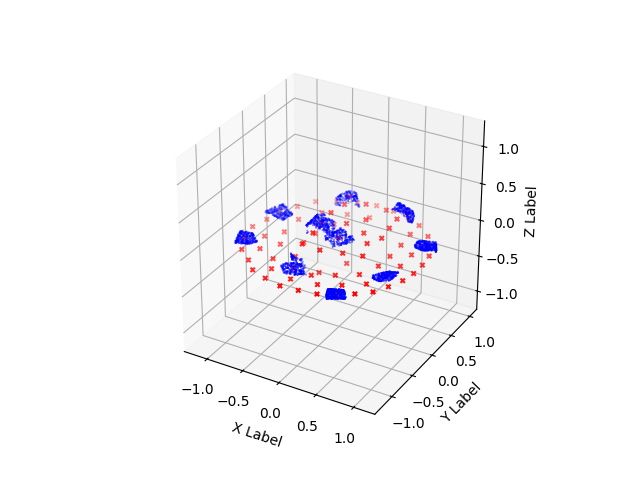

In [25]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = target_gaussians._xyz[np.concatenate(target_shape_idcs[0:10], axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(target_shape_cluster_centers[:, 0],
           target_shape_cluster_centers[:, 1],
           target_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



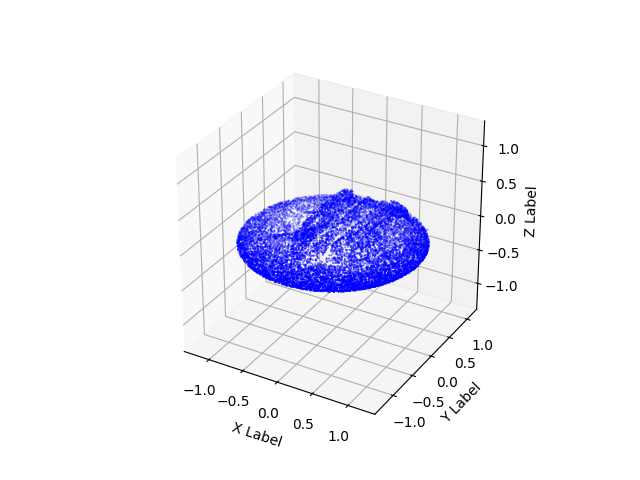

In [15]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=20
if True:
    arr_shape = target_gaussians._xyz.detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



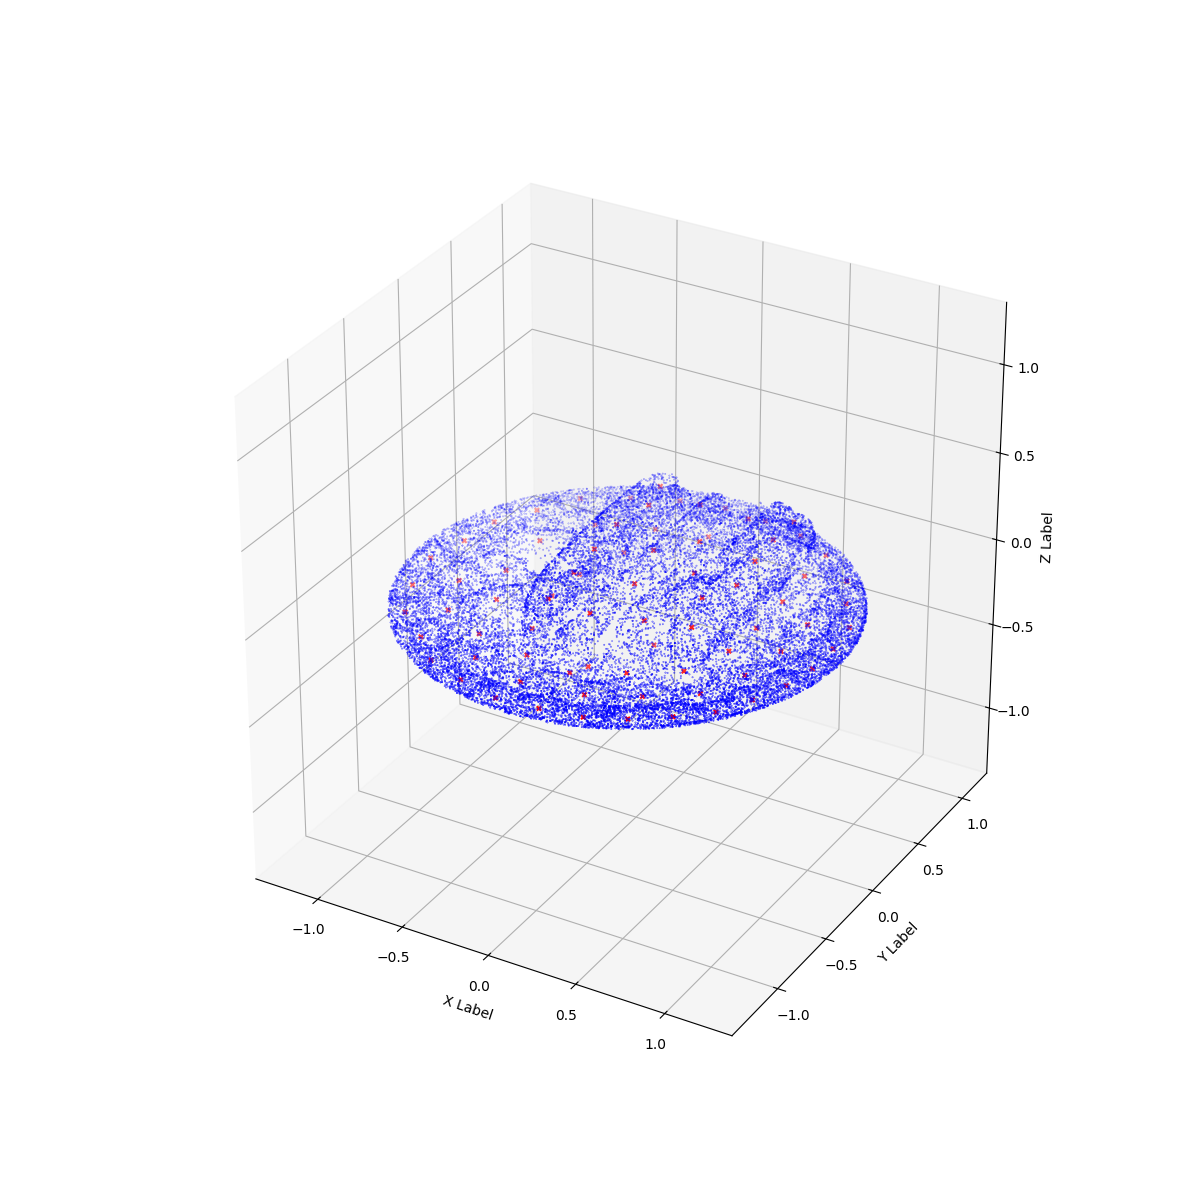

In [16]:

# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = target_gaussians._xyz[np.concatenate(target_shape_idcs, axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(target_shape_cluster_centers[:, 0],
           target_shape_cluster_centers[:, 1],
           target_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



## GMM clustering

In [563]:
from sklearn.mixture import GaussianMixture
! date
gm = GaussianMixture(n_components=50, random_state=0).fit(target_gaussians._xyz[::10].detach().cpu().numpy())
! date

Mon Nov  6 12:50:49 PST 2023
Mon Nov  6 12:50:58 PST 2023


## Kernel density estimation

In [23]:
from sklearn.neighbors import KernelDensity
! date
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(target_gaussians._xyz[::1].detach().cpu().numpy())
! date
#kde.score_samples(X)

Mon Nov  6 13:01:23 PST 2023
Mon Nov  6 13:01:24 PST 2023


In [24]:
! date
target_gaussians_densities = kde.score_samples(target_gaussians._xyz[::100].detach().cpu().numpy())
! date

Mon Nov  6 13:01:25 PST 2023
Mon Nov  6 13:02:08 PST 2023


In [19]:
target_gaussians_densities

array([ 0.10135704,  0.2698865 ,  0.49151895, ..., -0.03425246,
       -0.39256687,  0.43156915])

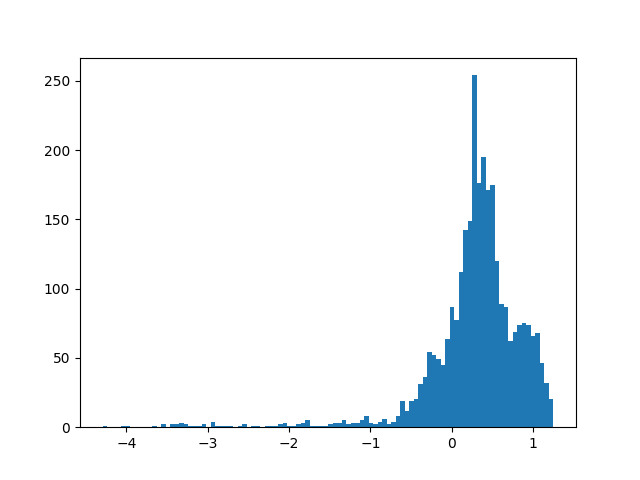

In [20]:
plt.figure()
plt.hist(target_gaussians_densities, bins=100)
plt.show()

In [ ]:

# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=100
if True:
    arr_shape = target_gaussians._xyz[np.concatenate(target_shape_idcs, axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], 
               c=arr_shape*0, marker='o',s=0.1)

ax.scatter(target_shape_cluster_centers[:, 0],
           target_shape_cluster_centers[:, 1],
           target_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [559]:
gm.means_

array([[-0.70778783,  0.26404043, -0.07257642],
       [ 0.53993373, -0.78297218, -0.08825357],
       [ 0.15977607,  0.95764784, -0.06241378],
       [ 1.07338852, -0.40296055, -0.0686767 ],
       [-0.35713753, -0.92873899, -0.09107782],
       [-0.16516035,  0.59147666,  0.21048265],
       [ 0.51826685,  0.33182798,  0.21726638],
       [-0.43766832,  0.5989727 , -0.11146501],
       [ 0.44063858, -1.16007779, -0.07165467],
       [-0.07019989, -0.70789794,  0.11139211],
       [ 0.84918118, -0.88399994, -0.0722054 ],
       [ 0.56859403, -0.34540986,  0.18615316],
       [ 1.09476683,  0.09163356, -0.06856417],
       [-0.97763727,  0.28764294, -0.08549455],
       [ 0.12110323, -0.99584716, -0.08940424],
       [-0.61834226, -0.36414015, -0.09300832],
       [ 0.8878517 ,  0.47947142, -0.06324006],
       [-0.87751936, -0.11579458, -0.10373484],
       [-0.23986826, -0.13711631,  0.18605154],
       [ 0.58503515,  0.67744441,  0.13125017],
       [-0.19623798,  0.97525997, -0.074

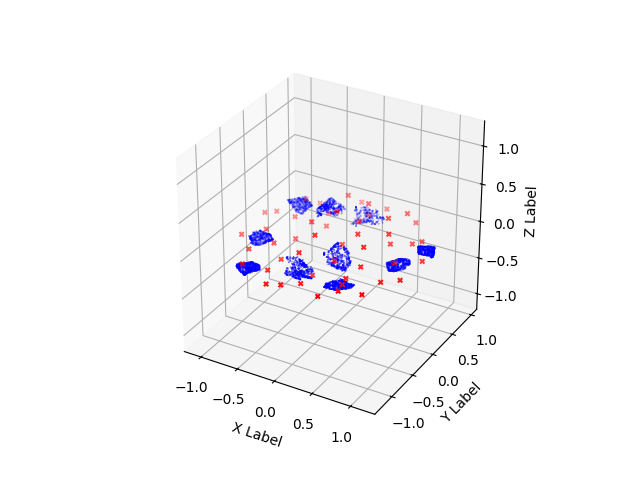

In [560]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = target_gaussians._xyz[np.concatenate(target_shape_idcs[0:10], axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(gm.means_[:, 0],
           gm.means_[:, 1],
           gm.means_[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [355]:
np.concatenate(target_shape_idcs, axis=0)

array([ 11661, 101322, 122218, ...,  24547,   3862, 127756])

In [365]:
print("yo")

yo


## Visualize style patches(clusters) at content scene cluster centers. 

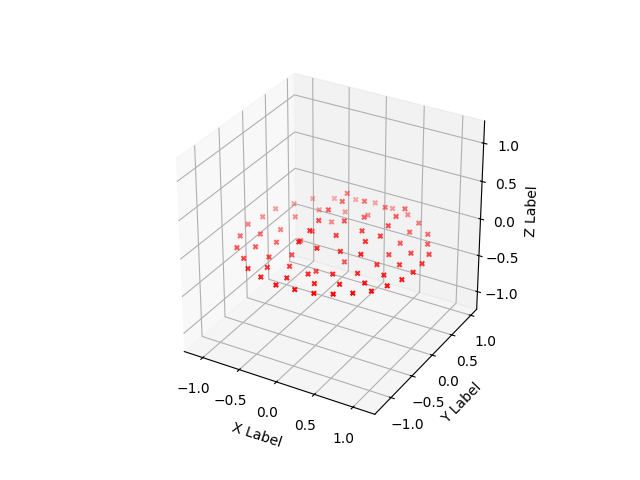

In [27]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if False:
    arr_shape = target_gaussians._xyz[np.concatenate(target_shape_idcs, axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(target_shape_cluster_centers[:, 0],
           target_shape_cluster_centers[:, 1],
           target_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



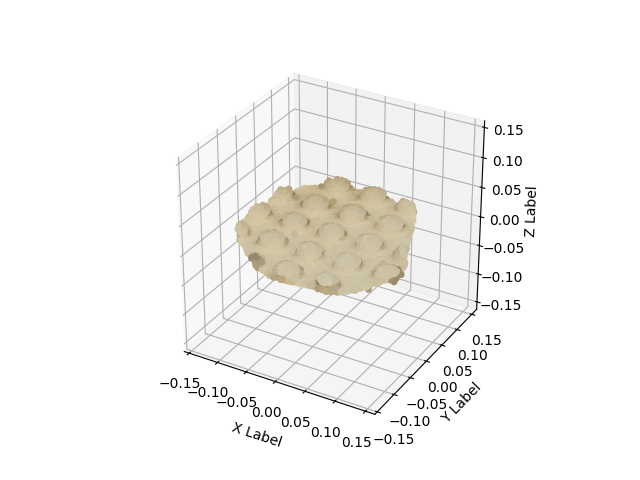

In [28]:
loaded_data = np.load("/home/dimakot55/output_data/gs/GT_lego_spheres_v5_clusters_100/cluster_51.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']

# 1. Remove poitns that are too far away from all othe points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
idcs_relevant = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
gaussians_xyz = loaded_data['_xyz'][idcs_relevant]
gaussians_features_dc = loaded_data['_features_dc'][idcs_relevant]
gaussians_features_rest = loaded_data['_features_rest'][idcs_relevant]
gaussians_rotation = loaded_data['_rotation'][idcs_relevant]
gaussians_scaling = loaded_data['_scaling'][idcs_relevant]
gaussians_opacity = loaded_data['_opacity'][idcs_relevant]

# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
#colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
colors=sigmoid(colors)

# preprocess sizes. Transform scaling to a format somewhat acceptable 
# by the ax.scatter function
sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

# Transform opacity to the format acceptable by ax.scatter
alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)



# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
ax.scatter(gaussians_xyz[:,0], 
           gaussians_xyz[:,1], 
           gaussians_xyz[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()





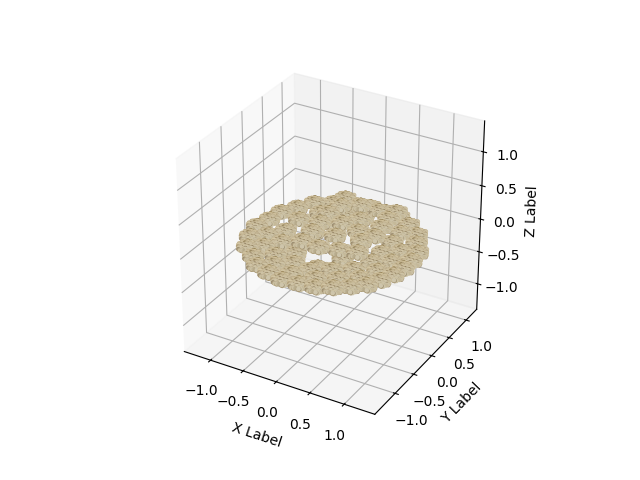

In [29]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
kth = 10
# Plot the scatter points
for cluster_center in target_shape_cluster_centers:
    ax.scatter(gaussians_xyz[::kth,0] + cluster_center[[0]], 
               gaussians_xyz[::kth,1] + cluster_center[[1]], 
               gaussians_xyz[::kth,2] + cluster_center[[2]], 
               c=np.concatenate([colors[::kth], alpha[::kth,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes[::kth]/3., #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()


### Now fit style patch to each individual cluster of the content scene




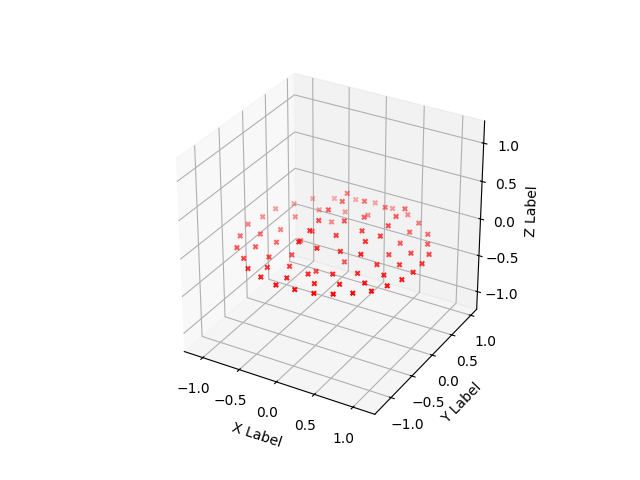

In [30]:
target_gaussians._xyz[np.concatenate(target_shape_idcs, axis=0)].detach().cpu().numpy()


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if False:
    arr_shape = target_gaussians._xyz[np.concatenate(target_shape_idcs, axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(target_shape_cluster_centers[:, 0],
           target_shape_cluster_centers[:, 1],
           target_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [31]:
target_shape_cluster_labels

array([ 0,  0,  0, ..., 79, 79, 79], dtype=int32)

In [32]:
len(target_shape_idcs)

80

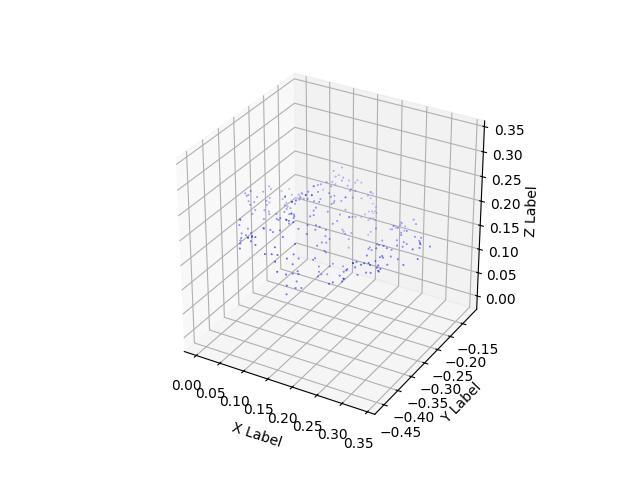

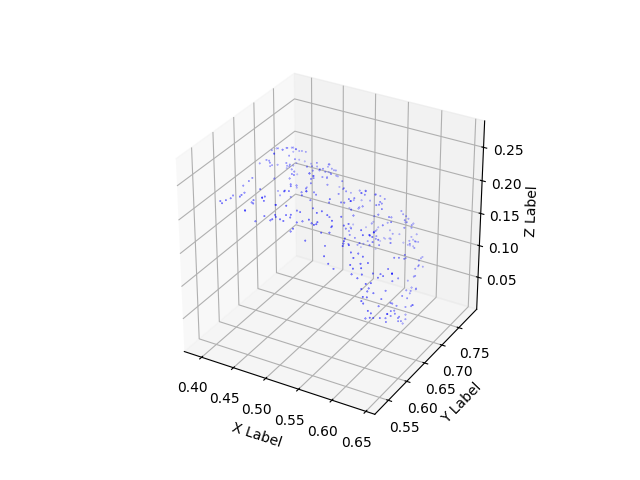

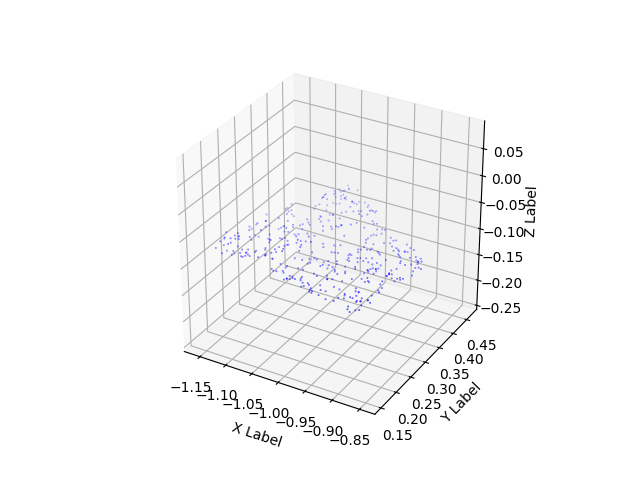

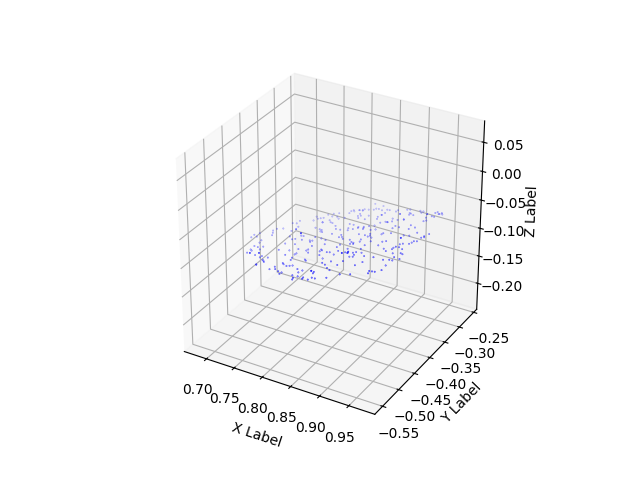

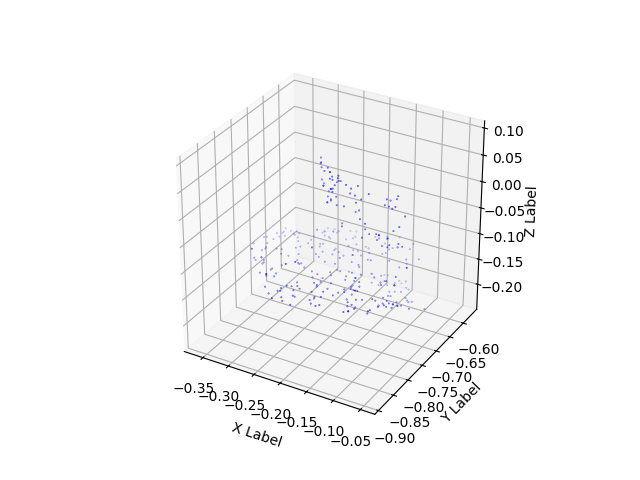

/tmp/ipykernel_910755/3618421230.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


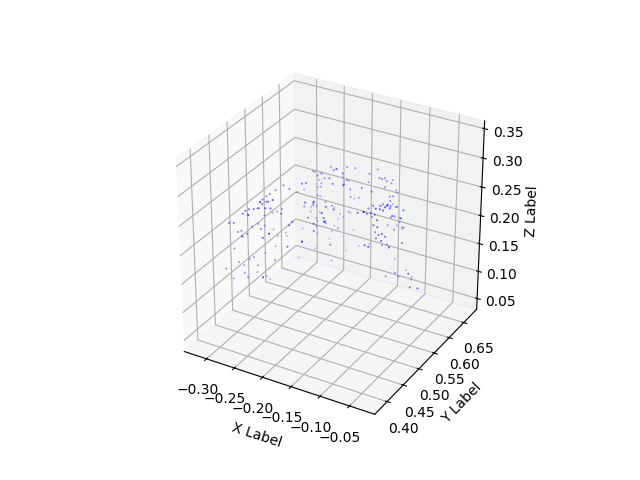

In [34]:
# target_shape_idcs, target_shape_cluster_centers, target_shape_cluster_labels
for cluster_domain_idcs in target_shape_idcs[0:6]:
    domain_points_cluster =  target_gaussians._xyz[cluster_domain_idcs]
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.axis('equal')
    ax.set_aspect('equal')
    # Plot target shape
    
    # Plot the scatter points
    if True:
        arr_shape = domain_points_cluster.detach().cpu().numpy()
        ax.scatter(arr_shape[:,0], 
                   arr_shape[:,1], 
                   arr_shape[:,2], c='b', marker='o',s=0.1)
    
    
    # # Plot optimized points
    # arr = target_points_cluster.detach().cpu().numpy()
    
    # ax.scatter(arr[:,0], 
    #            arr[:,1], 
    #            arr[:,2], 
    #            c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
    #            marker='o',
    #            s=sizes, #s=25.,
    #            #alpha=alpha,
    #            depthshade=False,
    #            edgecolors='none')
    #            #fillstyle='full',
    #            #markeredgecolor='red',
    #            #markeredgewidth=0.0)
    
    # Set labels for the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
    # ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
    set_axes_equal(ax) # IMPORTANT - this is also required
    plt.show()
    

In [37]:
def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns

def get_loss_domain_adaptation(X, domain, domain_NNs=20):
    """
    Try to approximate every point from X to the point from domain
    """
    
    D_to_domain = torch.cdist(X, domain)
    #print("D_to_domain.shape:", D_to_domain.shape)
    sorted_values, _ = torch.sort(D_to_domain, dim=1)  # Sort each row along dimension 1
    D_to_domain_mask = (D_to_domain <= sorted_values[:, domain_NNs - 1:domain_NNs])
    D_to_domain_mask = D_to_domain_mask.to(dtype=torch.float32)
    loss_D_to_domain = torch.mean(torch.square(D_to_domain)*D_to_domain_mask)
    # loss_D_to_domain = torch.mean(D_to_domain)
    return loss_D_to_domain
    
def fit_target_to_domain(target_points, domain_points, device="cuda", verbose=True):
    target_points_torch = torch.tensor(target_points, device=device)
    domain_points_torch = torch.tensor(domain_points.clone().detach(), device=device)
    
    domain_std = torch.std(domain_points_torch, dim=0)
    domain_mean = torch.mean(domain_points_torch, dim=0)
    points_torch = torch.nn.Parameter(torch.randn_like(target_points_torch, device=device) * domain_std + domain_mean ) 
    print(torch.std(domain_points_torch.detach(), dim=0))
    print(torch.mean(domain_points_torch.detach(), dim=0))

    
    print(domain_mean, domain_std)
    #points_torch = points_torch * domain_std * 2.  + domain_mean
    print("points_torch.shape:", points_torch.shape) 
    # Compute nearest neighbors and target descriptors for both points and vecs
    num_nns = 2000
    kth_nn = 50
    num_nns_local = 100
    kth_nn_local = 10
    distances = torch.cdist(target_points_torch, target_points_torch)
    _, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
    target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices[::kth_nn])
    print("target_descriptor_points.shape:", target_descriptor_points.shape)
    
    # Now add even stronger local loss
    
    _, nns_indices_local = torch.topk(distances, k=num_nns_local, largest=False, dim=-1)
    target_descriptor_points_local = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices_local[::kth_nn_local])
    print("target_descriptor_points.shape:", target_descriptor_points.shape)
    
    
    optimizer = torch.optim.Adam([points_torch], lr=1e-1)
    
    for iter in range(1001):
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[::kth_nn])
        loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[::kth_nn_local])
        loss_points_local2 = torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)
        
        loss = loss_points_local*5e0 + loss_points_local2*1e2 + loss_domain * 3e2
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if iter % 100 == 0 and verbose:
            print(f"loss_points_local:{loss_points_local:.7f}, loss_points_local2:{loss_points_local2:.7f}, loss_domain:{loss_domain:.7f}")


    return points_torch.detach()







/tmp/ipykernel_910755/851125957.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_points_torch = torch.tensor(domain_points.clone().detach(), device=device)


tensor([0.0820, 0.0816, 0.0295], device='cuda:0')
tensor([ 0.1500, -0.2749,  0.1770], device='cuda:0')
tensor([ 0.1500, -0.2749,  0.1770], device='cuda:0') tensor([0.0820, 0.0816, 0.0295], device='cuda:0')
points_torch.shape: torch.Size([2716, 3])
target_descriptor_points.shape: torch.Size([55, 1999])
target_descriptor_points.shape: torch.Size([55, 1999])
loss_points_local:0.0106367, loss_points_local2:0.0238478, loss_domain:0.0002247
loss_points_local:0.0010973, loss_points_local2:0.0000200, loss_domain:0.0000631
loss_points_local:0.0011193, loss_points_local2:0.0000192, loss_domain:0.0000617
loss_points_local:0.0011196, loss_points_local2:0.0000192, loss_domain:0.0000617
loss_points_local:0.0011183, loss_points_local2:0.0000192, loss_domain:0.0000617
loss_points_local:0.0011180, loss_points_local2:0.0000192, loss_domain:0.0000617
loss_points_local:0.0011192, loss_points_local2:0.0000193, loss_domain:0.0000617
loss_points_local:0.0011195, loss_points_local2:0.0000194, loss_domain:0.00

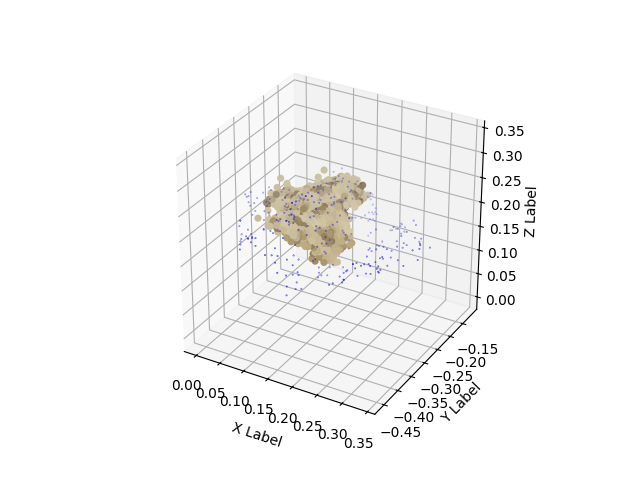

tensor([0.0722, 0.0710, 0.0522], device='cuda:0')
tensor([0.5369, 0.6515, 0.1755], device='cuda:0')
tensor([0.5369, 0.6515, 0.1755], device='cuda:0') tensor([0.0722, 0.0710, 0.0522], device='cuda:0')
points_torch.shape: torch.Size([2716, 3])
target_descriptor_points.shape: torch.Size([55, 1999])
target_descriptor_points.shape: torch.Size([55, 1999])
loss_points_local:0.0074474, loss_points_local2:0.0194530, loss_domain:0.0002123
loss_points_local:0.0001769, loss_points_local2:0.0000093, loss_domain:0.0000460
loss_points_local:0.0001170, loss_points_local2:0.0000070, loss_domain:0.0000455
loss_points_local:0.0001136, loss_points_local2:0.0000070, loss_domain:0.0000450
loss_points_local:0.0001136, loss_points_local2:0.0000070, loss_domain:0.0000450
loss_points_local:0.0001135, loss_points_local2:0.0000070, loss_domain:0.0000450
loss_points_local:0.0001132, loss_points_local2:0.0000071, loss_domain:0.0000450
loss_points_local:0.0001131, loss_points_local2:0.0000076, loss_domain:0.0000450


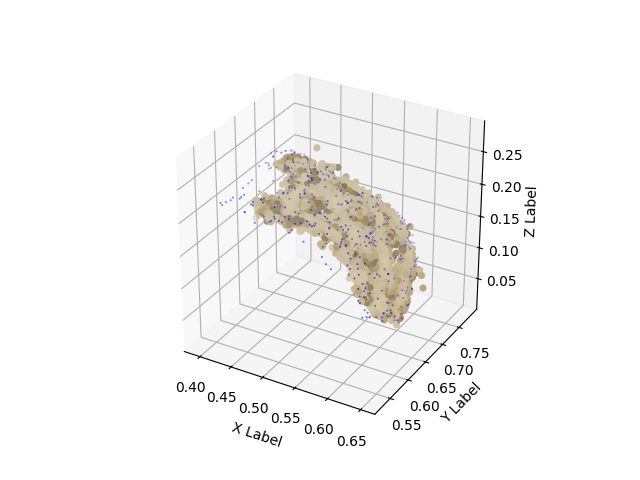

tensor([0.0820, 0.0783, 0.0112], device='cuda:0')
tensor([-0.9948,  0.2842, -0.0844], device='cuda:0')
tensor([-0.9948,  0.2842, -0.0844], device='cuda:0') tensor([0.0820, 0.0783, 0.0112], device='cuda:0')
points_torch.shape: torch.Size([2716, 3])
target_descriptor_points.shape: torch.Size([55, 1999])
target_descriptor_points.shape: torch.Size([55, 1999])
loss_points_local:0.0082379, loss_points_local2:0.0194891, loss_domain:0.0000781
loss_points_local:0.0000812, loss_points_local2:0.0000078, loss_domain:0.0000309
loss_points_local:0.0000514, loss_points_local2:0.0000049, loss_domain:0.0000304
loss_points_local:0.0000512, loss_points_local2:0.0000048, loss_domain:0.0000304
loss_points_local:0.0000512, loss_points_local2:0.0000048, loss_domain:0.0000304
loss_points_local:0.0000512, loss_points_local2:0.0000048, loss_domain:0.0000304
loss_points_local:0.0000511, loss_points_local2:0.0000051, loss_domain:0.0000305
loss_points_local:0.0000512, loss_points_local2:0.0000049, loss_domain:0.00

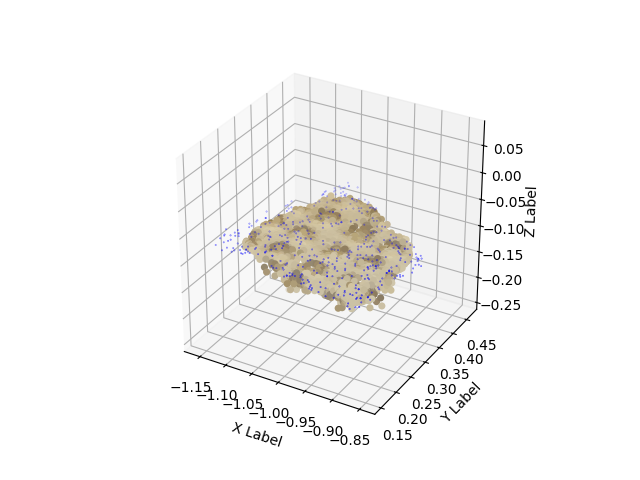

tensor([0.0671, 0.0771, 0.0120], device='cuda:0')
tensor([ 0.8409, -0.3968, -0.0844], device='cuda:0')
tensor([ 0.8409, -0.3968, -0.0844], device='cuda:0') tensor([0.0671, 0.0771, 0.0120], device='cuda:0')
points_torch.shape: torch.Size([2716, 3])
target_descriptor_points.shape: torch.Size([55, 1999])
target_descriptor_points.shape: torch.Size([55, 1999])
loss_points_local:0.0068193, loss_points_local2:0.0156519, loss_domain:0.0000989
loss_points_local:0.0007433, loss_points_local2:0.0000139, loss_domain:0.0000401
loss_points_local:0.0002358, loss_points_local2:0.0000110, loss_domain:0.0000390
loss_points_local:0.0002254, loss_points_local2:0.0000107, loss_domain:0.0000389
loss_points_local:0.0002254, loss_points_local2:0.0000107, loss_domain:0.0000389
loss_points_local:0.0002258, loss_points_local2:0.0000107, loss_domain:0.0000389
loss_points_local:0.0002296, loss_points_local2:0.0000115, loss_domain:0.0000389
loss_points_local:0.0002153, loss_points_local2:0.0000108, loss_domain:0.00

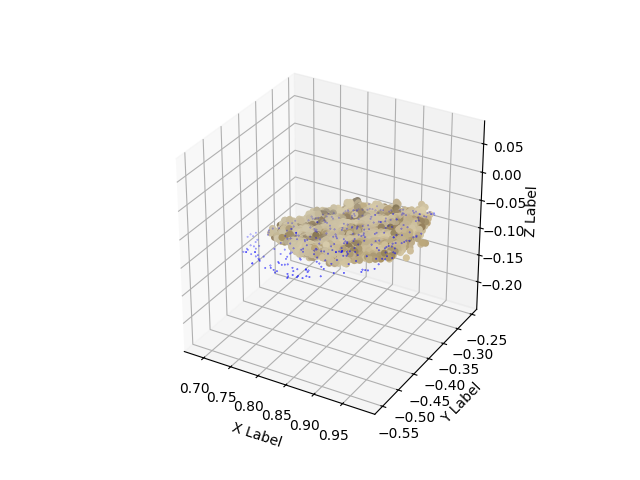

tensor([0.0737, 0.0697, 0.0642], device='cuda:0')
tensor([-0.1921, -0.7259, -0.1001], device='cuda:0')
tensor([-0.1921, -0.7259, -0.1001], device='cuda:0') tensor([0.0737, 0.0697, 0.0642], device='cuda:0')
points_torch.shape: torch.Size([2716, 3])
target_descriptor_points.shape: torch.Size([55, 1999])
target_descriptor_points.shape: torch.Size([55, 1999])
loss_points_local:0.0088934, loss_points_local2:0.0233407, loss_domain:0.0002475
loss_points_local:0.0001556, loss_points_local2:0.0000104, loss_domain:0.0000642
loss_points_local:0.0001194, loss_points_local2:0.0000076, loss_domain:0.0000637
loss_points_local:0.0001178, loss_points_local2:0.0000075, loss_domain:0.0000635
loss_points_local:0.0001175, loss_points_local2:0.0000076, loss_domain:0.0000635
loss_points_local:0.0001172, loss_points_local2:0.0000075, loss_domain:0.0000635
loss_points_local:0.0001099, loss_points_local2:0.0000074, loss_domain:0.0000633
loss_points_local:0.0001006, loss_points_local2:0.0000071, loss_domain:0.00

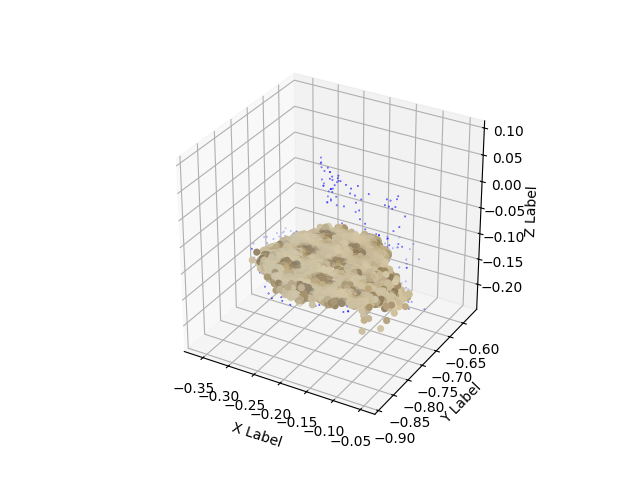

tensor([0.0793, 0.0804, 0.0667], device='cuda:0')
tensor([-0.1927,  0.5477,  0.2134], device='cuda:0')
tensor([-0.1927,  0.5477,  0.2134], device='cuda:0') tensor([0.0793, 0.0804, 0.0667], device='cuda:0')
points_torch.shape: torch.Size([2716, 3])
target_descriptor_points.shape: torch.Size([55, 1999])
target_descriptor_points.shape: torch.Size([55, 1999])
loss_points_local:0.0120699, loss_points_local2:0.0282366, loss_domain:0.0004941
loss_points_local:0.0017083, loss_points_local2:0.0000322, loss_domain:0.0001251
loss_points_local:0.0017048, loss_points_local2:0.0000301, loss_domain:0.0001237
loss_points_local:0.0017033, loss_points_local2:0.0000298, loss_domain:0.0001237
loss_points_local:0.0017032, loss_points_local2:0.0000299, loss_domain:0.0001237
loss_points_local:0.0017035, loss_points_local2:0.0000299, loss_domain:0.0001238
loss_points_local:0.0017006, loss_points_local2:0.0000298, loss_domain:0.0001238
loss_points_local:0.0016778, loss_points_local2:0.0000302, loss_domain:0.00

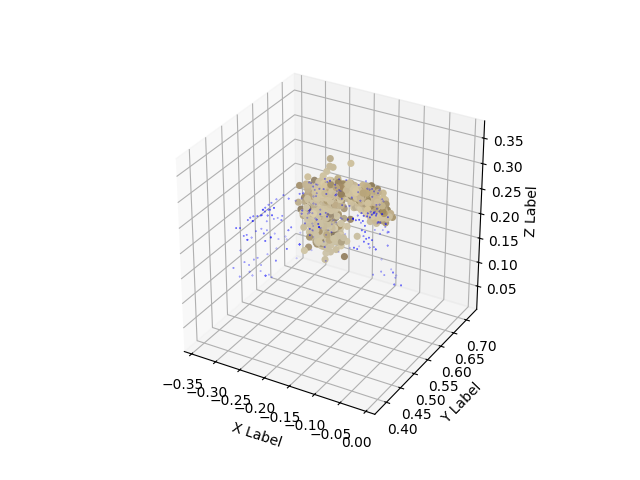

In [38]:
# target_shape_idcs, target_shape_cluster_centers, target_shape_cluster_labels
for cluster_domain_idcs in target_shape_idcs[0:6]:
    domain_points_cluster =  target_gaussians._xyz[cluster_domain_idcs]
    target_points_cluster = fit_target_to_domain(target_points=gaussians_xyz, 
                                                 domain_points=domain_points_cluster)
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.axis('equal')
    ax.set_aspect('equal')
    # Plot target shape
    
    # Plot the scatter points
    if True:
        arr_shape = domain_points_cluster.detach().cpu().numpy()
        ax.scatter(arr_shape[:,0], 
                   arr_shape[:,1], 
                   arr_shape[:,2], c='b', marker='o',s=0.1)
    
    
    # # Plot optimized points
    arr = target_points_cluster.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes, #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)
    
    # Set labels for the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
    # ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
    set_axes_equal(ax) # IMPORTANT - this is also required
    plt.show()






In [ ]:
# target_shape_idcs, target_shape_cluster_centers, target_shape_cluster_labels
for cluster_domain_idcs in target_shape_idcs[0:6]:
    domain_points_cluster =  target_gaussians._xyz[cluster_domain_idcs]
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.axis('equal')
    ax.set_aspect('equal')
    # Plot target shape
    
    # Plot the scatter points
    if True:
        arr_shape = domain_points_cluster.detach().cpu().numpy()
        ax.scatter(arr_shape[:,0], 
                   arr_shape[:,1], 
                   arr_shape[:,2], c='b', marker='o',s=0.1)
    
    
    # # Plot optimized points
    # arr = target_points_cluster.detach().cpu().numpy()
    
    # ax.scatter(arr[:,0], 
    #            arr[:,1], 
    #            arr[:,2], 
    #            c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
    #            marker='o',
    #            s=sizes, #s=25.,
    #            #alpha=alpha,
    #            depthshade=False,
    #            edgecolors='none')
    #            #fillstyle='full',
    #            #markeredgecolor='red',
    #            #markeredgewidth=0.0)
    
    # Set labels for the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
    # ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
    set_axes_equal(ax) # IMPORTANT - this is also required
    plt.show()
    

In [ ]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
if True:
    arr_shape = domain_points_torch.detach().cpu().numpy()
    arr_shape = domain_points_cluster.detach().cpu().numpy()
    ax.scatter(arr_shape[:,0], 
               arr_shape[:,1], 
               arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_cluster.detach().cpu().numpy()

ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [363]:
target_gaussians._xyz.shape, target_gaussians._xyz[np.concatenate(target_shape_idcs, axis=0)].shape

(torch.Size([294025, 3]), torch.Size([29386, 3]))

## Crop the center to ease debugging

In [306]:
u,d = 0.5,-0.5
indcs = torch.where(torch.min((target_gaussians._xyz>d)*(target_gaussians._xyz<u), dim=-1)[0])

for attr in ['_xyz', '_features_dc', '_features_rest', '_rotation', '_scaling', '_opacity']:
    setattr(target_gaussians, attr, getattr(target_gaussians, attr)[indcs])

#target_gaussians._xyz = target_gaussians._xyz[indcs]

In [307]:
indcs

(tensor([], device='cuda:0', dtype=torch.int64),)

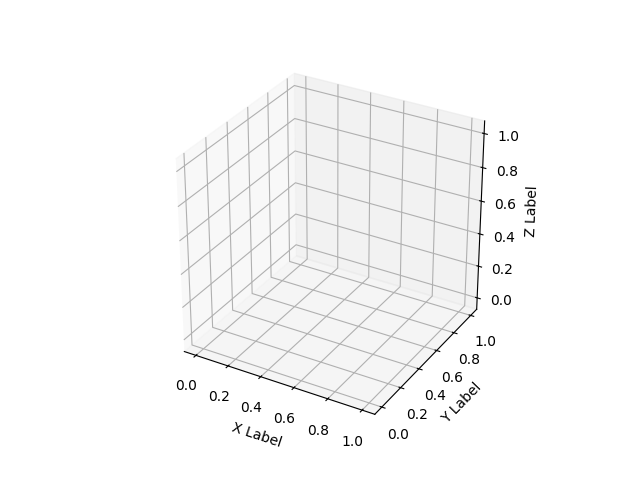

In [308]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=20
if True:
    arr_shape = target_gaussians._xyz.detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [235]:
# Clean noisy points. 
from scipy.spatial import distance
k=30
pairwise_distances = torch.cdist(torch.tensor(arr_shape, device="cuda"), 
                                 torch.tensor(arr_shape, device="cuda"))
# Use np.partition to find the k-th smallest distances for each row

# kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
# torch.topk
# kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
# q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
# idcs_relevant = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]

# arr_shape=arr_shape[idcs_relevant]

In [236]:
kth_nearest_dists, kth_nearest_indices = torch.topk(pairwise_distances, k=k, dim=1, largest=False, sorted=True)
q_outliers = torch.quantile(kth_nearest_dists[:, k-1], q=0.925)
#q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
print(q_outliers)

tensor(0.0654, device='cuda:0')


In [237]:
kth_nearest_dists

tensor([[0.0000, 0.0120, 0.0128,  ..., 0.0284, 0.0285, 0.0288],
        [0.0000, 0.0190, 0.0227,  ..., 0.0652, 0.0656, 0.0662],
        [0.0000, 0.0109, 0.0115,  ..., 0.0731, 0.0757, 0.0767],
        ...,
        [0.0000, 0.0058, 0.0061,  ..., 0.0188, 0.0189, 0.0192],
        [0.0000, 0.0064, 0.0067,  ..., 0.0201, 0.0202, 0.0204],
        [0.0000, 0.0056, 0.0059,  ..., 0.0178, 0.0185, 0.0187]],
       device='cuda:0')

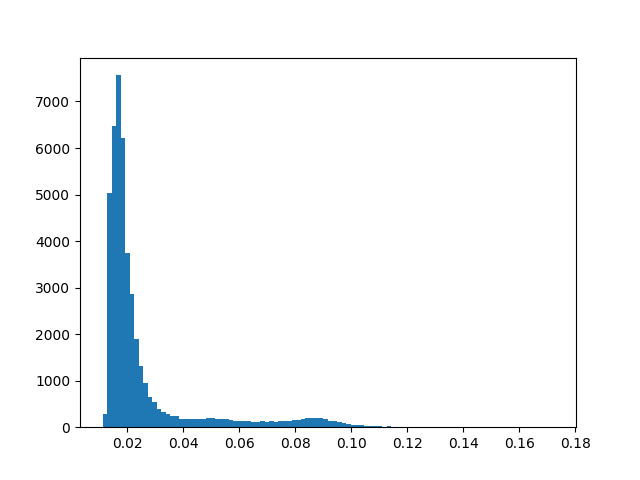

In [238]:
plt.figure()
plt.hist(kth_nearest_dists[:, k-1].detach().cpu().numpy().flatten(), bins=100)
plt.show()

In [239]:
indcs_relevant = torch.where(kth_nearest_dists[:, k-1] < q_outliers)[0]

In [240]:

indcs_relevant

tensor([    0,     6,     9,  ..., 45168, 45169, 45170], device='cuda:0')

In [241]:
arr_shape.shape, len(indcs_relevant)

((45171, 3), 41783)

# Cluster poitns

In [242]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(init="k-means++", n_clusters=100, n_init=4)
kmeans.fit(arr_shape)

KMeans(n_clusters=100, n_init=4)

In [243]:
kmeans.labels_

array([26, 79, 64, ..., 40, 51, 84], dtype=int32)

In [244]:
len(kmeans.labels_)

45171

In [313]:
indcs_relevant.shape

torch.Size([41783])

In [316]:
indcs_relevant

tensor([    0,     6,     9,  ..., 45168, 45169, 45170], device='cuda:0')

In [325]:
target_gaussians._xyz[indcs_relevant].shape

torch.Size([41783, 3])

In [317]:
torch.tensor([11, 23, 423])

tensor([ 11,  23, 423])

In [328]:

target_gaussians._xyz[[11, 23, 423]]

tensor([[ 0.1197, -0.6003,  0.1741],
        [ 0.5746, -0.8761, -0.0528],
        [-0.1884, -0.5607,  0.1014]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [327]:
target_gaussians._xyz[torch.tensor([11, 23, 423])]

tensor([[ 0.1197, -0.6003,  0.1741],
        [ 0.5746, -0.8761, -0.0528],
        [-0.1884, -0.5607,  0.1014]], device='cuda:0',
       grad_fn=<IndexBackward0>)

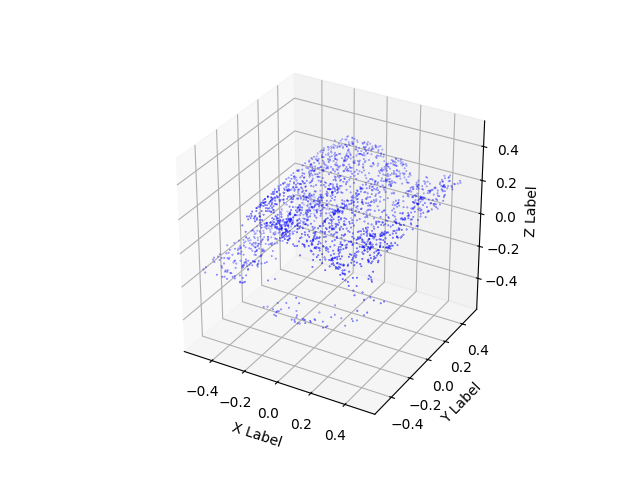

In [303]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=20
if True:
    arr_shape = target_gaussians._xyz[indcs_relevant].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [270]:
def sample_points_by_density(points, num_samples=None, radius = 0.05):
    """
    Samples points inversely proportional to their density in the neighborhood.
    :param points: torch tensor of shape [N,3]
    
    """
    import torch
    import torch.nn.functional as F
    
    # Assuming you have a PyTorch tensor of shape [N, 3] representing points
    # Calculate pairwise distances between all points
    # Note that i only compute distance to every 10th neighbor.
    distances = torch.cdist(points, points[::10])
    
    
    # Calculate the number of points within the local region for each point
    num_points_in_local_region = (distances <= radius).sum(dim=1)
    
    # Calculate the inverse density as a weight
    inverse_density = 1.0 / (num_points_in_local_region + 1)  # Add 1 to avoid division by zero
    
    # Normalize the weights to create a probability distribution
    probability_distribution = inverse_density / inverse_density.sum()
    
    # Sample points inversely proportional to their density
    if num_samples is None:
        
        num_samples = len(points) // 10  # Adjust the number of samples as needed
    sampled_indices = torch.multinomial(probability_distribution, num_samples, replacement=True)
    
    # Get the sampled points
    sampled_points = points[sampled_indices]
    
    # The 'sampled_points' tensor now contains points sampled inversely proportional to their density
    return sampled_points

In [265]:
target_gaussians._xyz[idcs_relevant].shape

torch.Size([2716, 3])

In [304]:
target_gaussians_resampled = sample_points_by_density(points=target_gaussians._xyz[indcs_relevant], 
                                                      num_samples=10_000,
                                                      radius=0.05)



In [297]:
target_gaussians._xyz.shape, target_gaussians._xyz[indcs_relevant].shape, target_gaussians_resampled.shape

(torch.Size([45171, 3]), torch.Size([41783, 3]), torch.Size([4178, 3]))

In [298]:
target_gaussians_resampled.shape

torch.Size([4178, 3])

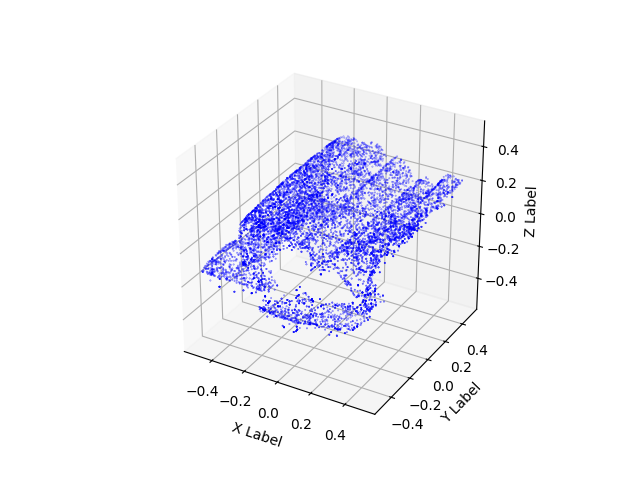

In [305]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = target_gaussians_resampled.detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [309]:

cmap = plt.get_cmap("Set1", max(kmeans.labels_))
colors = cmap(kmeans.labels_)

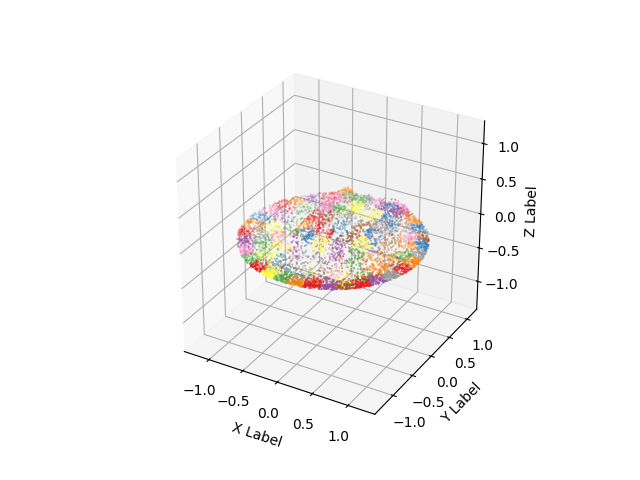

In [125]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
if True:
    arr_shape = target_gaussians._xyz.detach().cpu().numpy()
    ax.scatter(arr_shape[::50,0], 
               arr_shape[::50,1], 
               arr_shape[::50,2], 
               c=colors[::50], 
               marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

# Load single cluster to tile the target shape

In [126]:
loaded_data = np.load("/home/dimakot55/output_data/gs/GT_lego_spheres_v5_clusters_100/cluster_51.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']

In [127]:
# 1. Remove poitns that are too far away from all othe points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
idcs_relevant = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
gaussians_xyz = loaded_data['_xyz'][idcs_relevant]
gaussians_features_dc = loaded_data['_features_dc'][idcs_relevant]
gaussians_features_rest = loaded_data['_features_rest'][idcs_relevant]
gaussians_rotation = loaded_data['_rotation'][idcs_relevant]
gaussians_scaling = loaded_data['_scaling'][idcs_relevant]
gaussians_opacity = loaded_data['_opacity'][idcs_relevant]

# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
#colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
colors=sigmoid(colors)

# preprocess sizes. Transform scaling to a format somewhat acceptable 
# by the ax.scatter function
sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

# Transform opacity to the format acceptable by ax.scatter
alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)



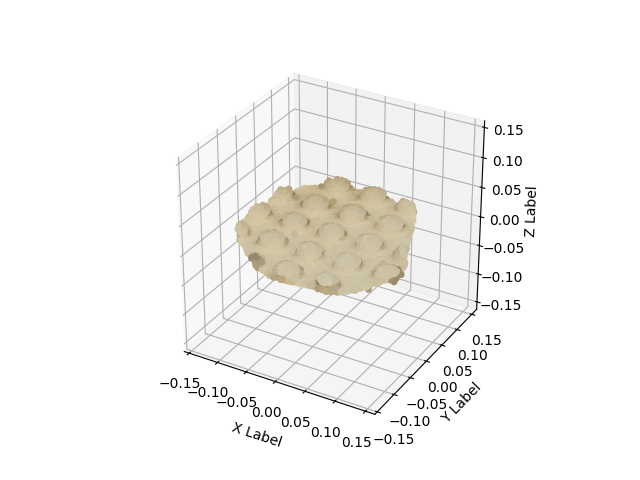

In [128]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
ax.scatter(gaussians_xyz[:,0], 
           gaussians_xyz[:,1], 
           gaussians_xyz[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [129]:
def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns

def get_loss_domain_adaptation(X, domain, domain_NNs=20):
    """
    Try to approximate every point from X to the point from domain
    """
    
    D_to_domain = torch.cdist(X, domain)
    #print("D_to_domain.shape:", D_to_domain.shape)
    sorted_values, _ = torch.sort(D_to_domain, dim=1)  # Sort each row along dimension 1
    D_to_domain_mask = (D_to_domain <= sorted_values[:, domain_NNs - 1:domain_NNs])
    D_to_domain_mask = D_to_domain_mask.to(dtype=torch.float32)
    loss_D_to_domain = torch.mean(torch.square(D_to_domain)*D_to_domain_mask)
    # loss_D_to_domain = torch.mean(D_to_domain)
    return loss_D_to_domain

In [135]:
def fit_target_to_domain(target_points, domain_points, device="cuda", verbose=True):
    target_points_torch = torch.tensor(target_points, device=device)
    domain_points_torch = torch.tensor(domain_points.clone().detach(), device=device)
    
    domain_std = torch.std(domain_points_torch, dim=0)
    domain_mean = torch.mean(domain_points_torch, dim=0)
    points_torch = torch.nn.Parameter(torch.randn_like(target_points_torch, device=device) * domain_std + domain_mean ) 
    print(torch.std(domain_points_torch.detach(), dim=0))
    print(torch.mean(domain_points_torch.detach(), dim=0))

    
    print(domain_mean, domain_std)
    #points_torch = points_torch * domain_std * 2.  + domain_mean
    print("points_torch.shape:", points_torch.shape) 
    # Compute nearest neighbors and target descriptors for both points and vecs
    num_nns = 2000
    kth_nn = 50
    num_nns_local = 100
    kth_nn_local = 10
    distances = torch.cdist(target_points_torch, target_points_torch)
    _, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
    target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices[::kth_nn])
    print("target_descriptor_points.shape:", target_descriptor_points.shape)
    
    # Now add even stronger local loss
    
    _, nns_indices_local = torch.topk(distances, k=num_nns_local, largest=False, dim=-1)
    target_descriptor_points_local = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices_local[::kth_nn_local])
    print("target_descriptor_points.shape:", target_descriptor_points.shape)
    
    
    optimizer = torch.optim.Adam([points_torch], lr=1e-1)
    
    for iter in range(1001):
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[::kth_nn])
        loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[::kth_nn_local])
        loss_points_local2 = torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)
        
        loss = loss_points_local*5e0 + loss_points_local2*1e2 + loss_domain * 3e2
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if iter % 100 == 0 and verbose:
            print(f"loss_points_local:{loss_points_local:.7f}, loss_points_local2:{loss_points_local2:.7f}, loss_domain:{loss_domain:.7f}")


    return points_torch.detach()
        

In [155]:

domain_points_cluster = target_gaussians._xyz[torch.where(torch.tensor(kmeans.labels_==19))[0]]
target_points_cluster = fit_target_to_domain(target_points=gaussians_xyz, 
                                             domain_points=domain_points_cluster)

/tmp/ipykernel_521220/2888529426.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_points_torch = torch.tensor(domain_points.clone().detach(), device=device)


tensor([0.0713, 0.0618, 0.0230], device='cuda:0')
tensor([-1.0776, -0.0599, -0.0835], device='cuda:0')
tensor([-1.0776, -0.0599, -0.0835], device='cuda:0') tensor([0.0713, 0.0618, 0.0230], device='cuda:0')
points_torch.shape: torch.Size([2716, 3])
target_descriptor_points.shape: torch.Size([55, 1999])
target_descriptor_points.shape: torch.Size([55, 1999])
loss_points_local:0.0062599, loss_points_local2:0.0143302, loss_domain:0.0000027
loss_points_local:0.0000873, loss_points_local2:0.0000025, loss_domain:0.0000023
loss_points_local:0.0000055, loss_points_local2:0.0000003, loss_domain:0.0000010
loss_points_local:0.0000048, loss_points_local2:0.0000003, loss_domain:0.0000009
loss_points_local:0.0000046, loss_points_local2:0.0000003, loss_domain:0.0000008
loss_points_local:0.0000045, loss_points_local2:0.0000003, loss_domain:0.0000008
loss_points_local:0.0000043, loss_points_local2:0.0000003, loss_domain:0.0000008
loss_points_local:0.0000042, loss_points_local2:0.0000002, loss_domain:0.00

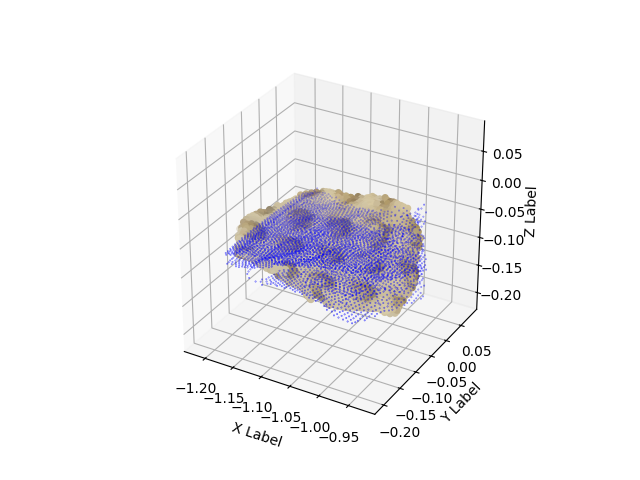

In [156]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
if True:
    arr_shape = domain_points_torch.detach().cpu().numpy()
    arr_shape = domain_points_cluster.detach().cpu().numpy()
    ax.scatter(arr_shape[:,0], 
               arr_shape[:,1], 
               arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_cluster.detach().cpu().numpy()

ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [33]:
device="cuda"
target_points_torch = torch.tensor(gaussians_xyz, device=device)
target_to_domain_scale = 3./ torch.mean(torch.linalg.norm(target_points_torch)) 
domain_points_torch = torch.tensor(target_gaussians._xyz.detach().clone()[::50], device=device) * target_to_domain_scale
# Old version with randomly initialized vector
points_torch = torch.nn.Parameter(torch.randn_like(target_points_torch, device=device)) 

# Compute nearest neighbors and target descriptors for both points and vecs
num_nns = 2000
distances = torch.cdist(target_points_torch, target_points_torch)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)µa
target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices)
print("target_descriptor_points.shape:", target_descriptor_points.shape)

# Now add even stronger local loss
num_nns = 100
_, nns_indices_local = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points_local = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices_local)
print("target_descriptor_points.shape:", target_descriptor_points.shape)


optimizer = torch.optim.Adam([points_torch], lr=1e-1)

for iter in range(1001):
    descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices)
    loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
    
    descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local)
    loss_points_local2 = torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
    
    loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)
    
    loss = loss_points_local*5e0 + loss_points_local2*1e2 + loss_domain * 3e2
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}, loss_points_local2:{loss_points_local2:.7f}, loss_domain:{loss_domain:.7f}")
        

/tmp/ipykernel_521220/3185658402.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_points_torch = torch.tensor(target_gaussians._xyz.detach().clone()[::50], device=device) * target_to_domain_scale


target_descriptor_points.shape: torch.Size([2716, 1999])
target_descriptor_points.shape: torch.Size([2716, 1999])
loss_points_local:5.6304736, loss_points_local2:5.9878230, loss_domain:0.0048035
loss_points_local:0.0024671, loss_points_local2:0.0000724, loss_domain:0.0000169
loss_points_local:0.0004651, loss_points_local2:0.0000059, loss_domain:0.0000167
loss_points_local:0.0001999, loss_points_local2:0.0000031, loss_domain:0.0000163
loss_points_local:0.0000638, loss_points_local2:0.0000014, loss_domain:0.0000158
loss_points_local:0.0000296, loss_points_local2:0.0000008, loss_domain:0.0000152
loss_points_local:0.0000190, loss_points_local2:0.0000006, loss_domain:0.0000145
loss_points_local:0.0000147, loss_points_local2:0.0000005, loss_domain:0.0000136
loss_points_local:0.0000124, loss_points_local2:0.0000004, loss_domain:0.0000124
loss_points_local:0.0000110, loss_points_local2:0.0000004, loss_domain:0.0000109
loss_points_local:0.0000101, loss_points_local2:0.0000004, loss_domain:0.000

In [ ]:
print('yo')

# Fit multiple details to a hotdog scene

In [26]:
from tqdm import tqdm_notebook as tqdm

In [37]:
device="cuda"
num_nns = 2000
kth_nn = 50
kth_nn_local = 10
NUM_PIECES=10
target_points_torch = torch.tensor(gaussians_xyz, device=device)
target_to_domain_scale = 3./ torch.mean(torch.linalg.norm(target_points_torch)) 
domain_points_torch = torch.tensor(target_gaussians._xyz.detach().clone()[::50], device=device) * target_to_domain_scale

# Old version with randomly initialized vector
points_torch_list = [torch.nn.Parameter(torch.randn_like(target_points_torch, device=device) * target_to_domain_scale) 
                     for _ in range(NUM_PIECES)]

# Compute nearest neighbors and target descriptors for both points and vecs
distances = torch.cdist(target_points_torch, target_points_torch)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices[:, ::kth_nn])
print("target_descriptor_points.shape:", target_descriptor_points.shape)

# Now add even stronger local loss
num_nns = 100
_, nns_indices_local = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points_local = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices_local[:, ::kth_nn_local])
print("target_descriptor_points.shape:", target_descriptor_points.shape)


optimizer = torch.optim.Adam(points_torch_list, lr=1e-1)

for iter in tqdm(range(1)):
    loss = 0.
    loss_points_local = 0.
    loss_points_local2 = 0.
    loss_domain = 0.
    loss_domain_coverage = 0.
    for points_torch in points_torch_list:
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[:, ::kth_nn])
        loss_points_local += torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[:, ::kth_nn_local])
        loss_points_local2 += torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain += get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)

    domain_to_cluster_D = torch.stack([torch.min(torch.cdist(domain_points_torch, points_torch_list[i]) , dim=-1)[0]
           for i in range(len(points_torch_list))], dim=1)
    loss_domain_coverage = torch.mean(torch.min(domain_to_cluster_D, axis=-1)[0])
    loss = loss_points_local*5e0 + loss_points_local2*5e1 + loss_domain * 3e2 + loss_domain_coverage * 1e1
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}", 
              f"loss_points_local2:{loss_points_local2:.7f}", 
              f"loss_domain:{loss_domain:.7f}",
              f"loss_domain_coverage:{loss_domain_coverage:.7f}"
              )
        

target_descriptor_points.shape: torch.Size([2716, 39])
target_descriptor_points.shape: torch.Size([2716, 39])


/tmp/ipykernel_1599934/1076899751.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain_points_torch = torch.tensor(target_gaussians._xyz.detach().clone()[::50], device=device) * target_to_domain_scale
/tmp/ipykernel_1599934/1076899751.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter in tqdm(range(1)):


  0%|          | 0/1 [00:00<?, ?it/s]

loss_points_local:17.4695969 loss_points_local2:19.5100250 loss_domain:0.1534444 loss_domain_coverage:0.0258554


In [35]:

optimizer = torch.optim.Adam(points_torch_list, lr=1e-2)
for iter in tqdm(range(1001)):
    loss = 0.
    loss_points_local = 0.
    loss_points_local2 = 0.
    loss_domain = 0.
    loss_domain_coverage = 0.
    for points_torch in points_torch_list:
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[:, ::kth_nn])
        loss_points_local += torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[:, ::kth_nn])
        loss_points_local2 += torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain += get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)

    domain_to_cluster_D = torch.stack([torch.min(torch.cdist(domain_points_torch, points_torch_list[i]) , dim=-1)[0]
           for i in range(len(points_torch_list))], dim=1)
    loss_domain_coverage = torch.mean(torch.min(domain_to_cluster_D, axis=-1)[0])
    loss = loss_points_local*5e0 + loss_points_local2*5e1 + loss_domain * 3e2 + loss_domain_coverage * 1e0
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}", 
              f"loss_points_local2:{loss_points_local2:.7f}", 
              f"loss_domain:{loss_domain:.7f}",
              f"loss_domain_coverage:{loss_domain_coverage:.7f}"
              )

/tmp/ipykernel_1599934/2623214190.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter in tqdm(range(1001)):


  0%|          | 0/1001 [00:00<?, ?it/s]

loss_points_local:0.0032010 loss_points_local2:0.0010179 loss_domain:0.0003437 loss_domain_coverage:0.0102580
loss_points_local:0.0017885 loss_points_local2:0.0003645 loss_domain:0.0003292 loss_domain_coverage:0.0066648
loss_points_local:0.0018516 loss_points_local2:0.0003713 loss_domain:0.0003299 loss_domain_coverage:0.0067609
loss_points_local:0.0019252 loss_points_local2:0.0003788 loss_domain:0.0003305 loss_domain_coverage:0.0068037
loss_points_local:0.0019610 loss_points_local2:0.0003862 loss_domain:0.0003314 loss_domain_coverage:0.0068188
loss_points_local:0.0020053 loss_points_local2:0.0003904 loss_domain:0.0003313 loss_domain_coverage:0.0069161
loss_points_local:0.0019730 loss_points_local2:0.0003888 loss_domain:0.0003314 loss_domain_coverage:0.0069056
loss_points_local:0.0019907 loss_points_local2:0.0003906 loss_domain:0.0003314 loss_domain_coverage:0.0068779
loss_points_local:0.0020045 loss_points_local2:0.0003918 loss_domain:0.0003317 loss_domain_coverage:0.0069536
loss_point

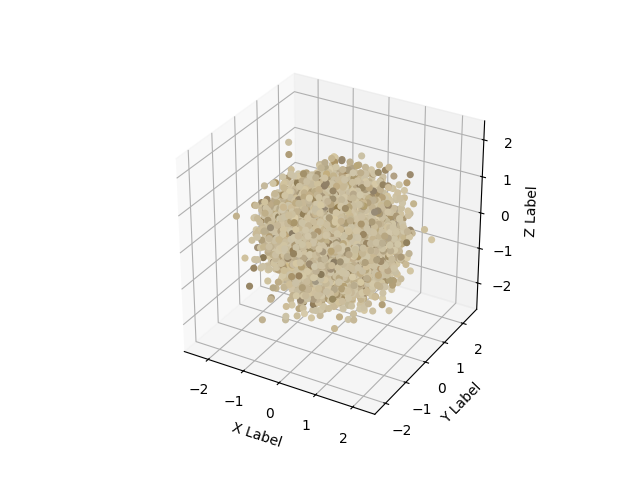

In [38]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
for points_torch in points_torch_list[:10]:
    arr = points_torch.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes, #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [71]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
#os.makedirs(MODEL_DIR, exist_ok = True)
gaussians_to_save = GaussianModel(sh_degree=3)
#gaussians_to_save.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_lego_cluster2/chkpnt1.pth")[0], opt)
gaussians_to_save.optimizer = torch.optim.Adam([gaussians_to_save._xyz], lr=1e-1)



# gaussians_xyz = loaded_data['_xyz'][idcs_relevant]
# gaussians_features_dc = loaded_data['_features_dc'][idcs_relevant]
# gaussians_features_rest = loaded_data['_features_rest'][idcs_relevant]
# gaussians_rotation = loaded_data['_rotation'][idcs_relevant]
# gaussians_scaling = loaded_data['_scaling'][idcs_relevant]
# gaussians_opacity = loaded_data['_opacity'][idcs_relevant]

# Store optimized parameters to the gaussias_to_save
N = len(points_torch_list)
gaussians_to_save._xyz = torch.tensor(torch.concat(points_torch_list, dim=0).clone().detach())
# gaussians_to_save._xyz = torch.tensor(target_points_torch).clone().detach()
gaussians_to_save._rotation = torch.tensor(np.concatenate([gaussians_rotation]*N, axis=0))
gaussians_to_save._features_dc = torch.tensor(np.concatenate([gaussians_features_dc]*N, axis=0))
gaussians_to_save._features_rest = torch.tensor(np.concatenate([gaussians_features_rest*0.]*N, axis=0))
gaussians_to_save._scaling = torch.tensor(np.concatenate([gaussians_scaling*0.885]*N, axis=0)) #was 0.885
gaussians_to_save._opacity = torch.tensor(np.concatenate([gaussians_opacity]*N, axis=0))


iteration=1
torch.save((gaussians_to_save.capture(), iteration), MODEL_DIR + "/chkpnt" + str(iteration) + ".pth")
gaussians_to_save.save_ply(os.path.join(MODEL_DIR, "point_cloud/iteration_1/", "point_cloud.ply"))



/tmp/ipykernel_3633336/3084336330.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_to_save._xyz = torch.tensor(torch.concat(points_torch_list, dim=0).clone().detach())
